In [1]:
import sys
from pathlib import Path

# 시각화
import plotly.express as px

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score

sys.path.append(str(Path.cwd().parent))
from utils import DATA_DIR, MODEL_DIR

In [47]:
import platform
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

mpl.rcParams['axes.unicode_minus'] = False
# 폰트 개인 경로에 맞춰서 변경
# FONT_DIR = Path("/path/to/fonts")
# font_path = FONT_DIR / 'FREESENTATION-6SEMIBOLD.ttf'
# prop = fm.FontProperties(fname=font_path)

In [48]:
pandas_kwargs = {
    'parse_dates': ['검정일자'],
    'date_format': '%Y-%m-%d'
}

milk: pd.DataFrame = pd.read_csv(DATA_DIR /'interim' / 'milk.csv', **pandas_kwargs)
milk.head()

,농장아이디,개체번호,검정일자,누적착유일(연계),무지고형분,MUN,305일유량,305일무지고형분,전산차비유지속성,전산차건유전유량,...,농장구분,정액코드분류,가격,가격미달,가격구분,분만간격,분만월령,공태일수_log,계절_sin,비유단계_sin
0,20249,20120709020022,2020-01-11,154,0,1,9714.0,805.0,50.5,16.1,...,1,NaN,1056.34,0,1,NaN,85,NaN,-2.449294e-16,1.000000e+00
1,20249,20120504020095,2020-01-11,52,0,1,NaN,NaN,68.8,22.6,...,1,NaN,1056.34,0,1,NaN,90,NaN,-2.449294e-16,1.000000e+00
2,20249,20111008020210,2020-01-11,115,0,1,11008.0,971.0,54.1,24.5,...,1,NaN,1060.34,0,1,NaN,95,NaN,-2.449294e-16,1.224647e-16
3,20249,20121014020049,2020-01-11,290,1,1,11318.0,1011.0,58.6,37.8,...,1,7HO,1062.31,0,1,NaN,77,5.4161,-2.449294e-16,-1.000000e+00
4,20249,20130812020216,2020-01-11,100,0,1,11324.0,957.0,68.1,20.5,...,1,NaN,1056.34,0,1,NaN,75,NaN,-2.449294e-16,1.224647e-16


In [4]:
df = milk

In [5]:
df.shape

(40264, 26)

In [6]:
df.info() # nan값은 pipeline으로 처리할 예정.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40264 entries, 0 to 40263
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   농장아이디        40264 non-null  int64         
 1   개체번호         40264 non-null  int64         
 2   검정일자         40264 non-null  datetime64[ns]
 3   누적착유일(연계)    40264 non-null  int64         
 4   무지고형분        40264 non-null  int64         
 5   MUN          40264 non-null  int64         
 6   305일유량       31766 non-null  float64       
 7   305일무지고형분    31766 non-null  float64       
 8   전산차비유지속성     17618 non-null  float64       
 9   전산차건유전유량     24721 non-null  float64       
 10  산차           40264 non-null  int64         
 11  농후사료비(연계)    40264 non-null  float64       
 12  농후사료급여량(연계)  40264 non-null  float64       
 13  공태일수         24538 non-null  float64       
 14  비유단계         40264 non-null  int64         
 15  계절           40264 non-null  int64         
 16  농장구분

In [7]:
df.describe()

,농장아이디,개체번호,검정일자,누적착유일(연계),무지고형분,MUN,305일유량,305일무지고형분,전산차비유지속성,전산차건유전유량,...,계절,농장구분,가격,가격미달,가격구분,분만간격,분만월령,공태일수_log,계절_sin,비유단계_sin
count,40264.000000,4.026400e+04,40264,40264.000000,40264.000000,40264.000000,31766.000000,31766.000000,17618.000000,24721.000000,...,40264.000000,40264.000000,40264.000000,40264.000000,40264.000000,16196.000000,40264.000000,24538.000000,4.026400e+04,4.026400e+04
mean,20909.488774,2.016502e+13,2021-01-21 09:32:45.587124992,197.482515,0.434110,0.409075,10815.974690,943.111566,75.316512,24.522285,...,2.563183,0.268081,961.174764,0.106994,0.773694,438.396703,43.929987,3.884824,-7.341546e-02,-1.422362e-01
min,20249.000000,2.007121e+13,2020-01-01 00:00:00,0.000000,0.000000,0.000000,2416.000000,174.000000,11.800000,2.400000,...,1.000000,0.000000,300.000000,0.000000,0.000000,181.000000,19.000000,0.000000,-1.000000e+00,-1.000000e+00
25%,20269.000000,2.015121e+13,2020-08-19 00:00:00,90.000000,0.000000,0.000000,9469.000000,825.000000,61.700000,19.500000,...,2.000000,0.000000,998.500000,0.000000,0.000000,364.000000,26.000000,3.951244,-1.000000e+00,-1.000000e+00
50%,21137.000000,2.017042e+13,2021-02-02 00:00:00,181.000000,0.000000,0.000000,10737.000000,934.000000,74.200000,24.600000,...,3.000000,0.000000,1060.300000,0.000000,1.000000,407.000000,38.000000,4.672829,-2.449294e-16,-2.449294e-16
75%,21276.000000,2.018041e+13,2021-07-06 00:00:00,280.000000,1.000000,1.000000,12132.750000,1059.000000,88.200000,29.700000,...,3.000000,1.000000,1075.750000,0.000000,1.000000,489.000000,55.000000,5.209486,1.224647e-16,1.224647e-16
max,21876.000000,2.021010e+13,2022-02-04 00:00:00,1050.000000,1.000000,1.000000,21284.000000,1768.000000,235.700000,58.000000,...,4.000000,1.000000,1075.750000,1.000000,2.000000,1167.000000,179.000000,6.882437,1.000000e+00,1.000000e+00
std,584.671255,1.937025e+10,NaN,133.528471,0.495646,0.491669,2023.436154,177.270165,19.972068,7.809552,...,1.072019,0.442965,233.757091,0.309109,0.623770,105.321359,21.302544,2.053194,6.938725e-01,7.069120e-01


In [8]:
df.columns

Index(['농장아이디', '개체번호', '검정일자', '누적착유일(연계)', '무지고형분', 'MUN', '305일유량',
       '305일무지고형분', '전산차비유지속성', '전산차건유전유량', '산차', '농후사료비(연계)', '농후사료급여량(연계)',
       '공태일수', '비유단계', '계절', '농장구분', '정액코드분류', '가격', '가격미달', '가격구분', '분만간격',
       '분만월령', '공태일수_log', '계절_sin', '비유단계_sin'],
      dtype='object')

In [9]:
features = ['누적착유일(연계)', '전산차비유지속성', '전산차건유전유량', '산차', '농후사료급여량(연계)',
       '공태일수_log', '비유단계_sin', '계절_sin', '농장구분', '정액코드분류','분만간격', '분만월령']

target = '가격구분'

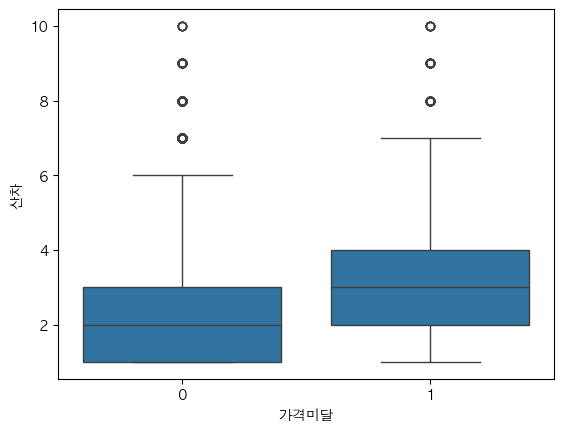

In [10]:
sns.boxplot(df, x=target, y='산차') # 우유등급별로 다른 결측치 처리를 해야겠음.
plt.show()

# 변수들 간의 상관관계 확인해서 review_score, monthly_avg_orders와 상관계수 높은 것들은 제거하거나 처리

In [11]:
vars = list(set(features + [target]) - set(['정액코드분류']))
corr_matrix = df[vars].corr('spearman').round(3)

fig_corr = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    title="Correlation Matrix (Plotly)",
    template="plotly_dark"
)
fig_corr.update_layout(
    xaxis_title="Features",
    yaxis_title="Features",
    width=1200, height=1000
)
fig_corr.show()



In [12]:
# 공태일수 - 누적착유일(연계)
# 산차 - 분만얼령
# 305일 무지고형분 - 305일 유량

vars = [
    # '누적착유일(연계)',
    '전산차비유지속성',
    '산차', 
    '농후사료급여량(연계)',
    # '공태일수',
    '공태일수_log',
    # '305일유량',
    '농장구분',
    # '분만간격',
    # '분만월령',
    # '비유단계',
    '비유단계_sin',
    # '계절',
    '계절_sin'
]

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X = df[vars].dropna()

vif_data = pd.DataFrame({
    "Feature": vars,
    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})

fig_vif = px.bar(
    vif_data.sort_values("VIF", ascending=True),
    x="VIF",
    y="Feature",
    orientation="h",
    title="Variance Inflation Factor (VIF) — 다중공선성 진단",
    template="plotly_dark",
    color="VIF",
    color_continuous_scale="Viridis"
)
fig_vif.add_vline(x=5, line_dash="dash", line_color="orange",
                  annotation_text="주의 경계선 (VIF=5)")
fig_vif.add_vline(x=10, line_dash="dot", line_color="red",
                  annotation_text="심각 (VIF=10)")
fig_vif.show()

# 피어슨, 스피어만 상관분석

In [ ]:
from scipy.stats import spearmanr


for feature in features:
    print('='*50)
    print(f'{feature}와 {target} 상관분석')
    print('='*50)
    
    temp = df.dropna(subset=[feature])
    r, pval = spearmanr(temp[target], temp[feature])
    print(f"Pearson correlation: r = {r:.3f}, p-value = {pval:.5f}")
    abs_r = abs(r)
    
    if abs_r < 0.1:
        effect = '매우 작은 효과'
    elif abs_r < 0.2:
        effect = '작은 효과'
    elif abs_r < 0.4:
        effect = '중간 효과'
    elif abs_r < 0.6:
        effect = '비교적 큰 효과'
    elif abs_r < 0.8:
        effect = '큰 효과'
    else:
        effect = '매우 큰 효과'
    print(effect)
    
    print()

누적착유일(연계)와 가격미달 상관분석
Pearson correlation: r = 0.060, p-value = 0.00000
매우 작은 효과

전산차건유전유량와 가격미달 상관분석
Pearson correlation: r = -0.051, p-value = 0.00000
매우 작은 효과

산차와 가격미달 상관분석
Pearson correlation: r = 0.154, p-value = 0.00000
작은 효과

농후사료급여량(연계)와 가격미달 상관분석
Pearson correlation: r = -0.004, p-value = 0.39835
매우 작은 효과

공태일수와 가격미달 상관분석
Pearson correlation: r = 0.038, p-value = 0.00000
매우 작은 효과

계절와 가격미달 상관분석
Pearson correlation: r = -0.012, p-value = 0.01588
매우 작은 효과

농장구분와 가격미달 상관분석
Pearson correlation: r = -0.006, p-value = 0.26087
매우 작은 효과

정액코드분류와 가격미달 상관분석
Pearson correlation: r = 0.006, p-value = 0.40707
매우 작은 효과

분만간격와 가격미달 상관분석
Pearson correlation: r = 0.048, p-value = 0.00000
매우 작은 효과



## 범주형 처리

In [ ]:
categorical_feature = ['정액코드분류']

df['정액코드분류'] = df['정액코드분류'].fillna('MISSING').astype('category')

# df train/test로 분리해야 함

In [ ]:
df[target].value_counts()

가격미달
0    35956
1     4308
Name: count, dtype: int64

In [ ]:
df['검정일자'].dt.year.value_counts()

검정일자
2021    22069
2020    18137
2022       58
Name: count, dtype: int64

In [ ]:
train = df[df['검정일자'].dt.year == 2020]
test = df[df['검정일자'].dt.year == 2021]

In [ ]:
X_train, X_test = train[features], test[features]
y_train, y_test = train[target], test[target]

# Pipeline 만들고 GridSearchCV 적용해서 best model 찾기!

SMOTE도 해보기

# 튜터님 조언: 단순 복제 oversampling 사용

In [ ]:
from imblearn.over_sampling import RandomOverSampler

## RF

## LightGBM

In [ ]:
import lightgbm as lgb
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")


RandomOverSampler 사용

In [ ]:
(y_train == 1).sum()

np.int64(1794)

In [ ]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight

np.float64(9.109810479375696)

## 임시

In [ ]:
minority_count = (y_train == 1).sum()  # 소수 (양성)
majority_count = (y_train == 0).sum()  # 다수 (음성)
scale_pos_weight = majority_count / minority_count

print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 9.11


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")


# Pipeline 구성 (RandomOverSampler + LightGBM)
pipeline = Pipeline([
    # ('oversample', RandomOverSampler(random_state=42)),
    ('clf', lgb.LGBMClassifier(
        objective='binary',
        device='gpu',
        random_state=42,
        verbosity=-1,
        scale_pos_weight=scale_pos_weight,
        error_score=np.nan,
        force_col_wise=True
    ))
])

param_grid = {
    'clf__n_estimators': [300],
    'clf__max_depth': [5],
    'clf__learning_rate': [0.05],
    'clf__min_child_samples': [1],
}


# scoring 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy'
}

# GridSearchCV 설정
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_macro',
    refit='f1_macro',  # 최종 모델은 f1_macro 기준 선택
    cv=5,
    # n_jobs=-1,
    verbose=2
)

# 학습
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_samples=1, clf__n_estimators=300; total time=   0.8s
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_samples=1, clf__n_estimators=300; total time=   0.7s
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_samples=1, clf__n_estimators=300; total time=   0.7s
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_samples=1, clf__n_estimators=300; total time=   0.7s
[CV] END clf__learning_rate=0.05, clf__max_depth=5, clf__min_child_samples=1, clf__n_estimators=300; total time=   0.7s


,estimator,Pipeline(step...rbosity=-1))])
,param_grid,"{'clf__learning_rate': [0.05], 'clf__max_depth': [5], 'clf__min_child_samples': [1], 'clf__n_estimators': [300]}"
,scoring,'f1_macro'
,n_jobs,None
,refit,'f1_macro'
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)


GridSearchCV 결과 요약:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.707683      0.023915          0.00687        0.000653   

   param_clf__learning_rate  param_clf__max_depth  \
0                      0.05                     5   

   param_clf__min_child_samples  param_clf__n_estimators  \
0                             1                      300   

                                              params  split0_test_score  \
0  {'clf__learning_rate': 0.05, 'clf__max_depth':...           0.219215   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.253525           0.356254           0.446368           0.551839   

   mean_test_score  std_test_score  rank_test_score  
0          0.36544        0.122707                1  

Best params (기준: f1_macro): {'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__min_child_samples': 1, 'clf__n_estimators': 300}
Best f1_macro score: 0.3654402223808823


In [ ]:
# 테스트셋 성능 평가
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)[:, 1]

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")


Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.883     0.645     0.746     23600
           1      0.243     0.570     0.340      4698

    accuracy                          0.633     28298
   macro avg      0.563     0.608     0.543     28298
weighted avg      0.777     0.633     0.678     28298


Balanced Accuracy (Test Set): 0.608
ROC-AUC (OvO, macro, Test Set): 0.644


In [ ]:
# 테스트셋 성능 평가
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)[:, 1]

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")


Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.239     0.581     0.339      4698
           1      0.883     0.632     0.737     23600

    accuracy                          0.623     28298
   macro avg      0.561     0.606     0.538     28298
weighted avg      0.776     0.623     0.671     28298


Balanced Accuracy (Test Set): 0.606
ROC-AUC (OvO, macro, Test Set): 0.647


In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

scale_pos_weight 사용

In [ ]:
from collections import Counter

counter = Counter(y_train)
print(counter)

# 기준 클래스 (다수 클래스)
major_class = 'group_0'
major_count = counter[major_class]

# scale_pos_weight 계산
scale_pos_weight = {cls: round(major_count / count, 2) for cls, count in counter.items()}
print(scale_pos_weight)

In [ ]:
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(counter),
    class_weight='scale_pos_weight',
    random_state=42
)

# 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'learning_rate': [0.05, 0.1],
    'min_child_samples': [1, 5, 10],
    'min_gain_to_split': [0, 0.01, 0.05]
}

# scoring 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy'
}

# GridSearchCV
grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train)

In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_n_estimators', 'param_max_depth', 'param_learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)

In [ ]:
# 테스트셋 성능 평가
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## class_weight='balanced', 하이퍼파라미터 튜닝 변경

In [ ]:
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    class_weight='balanced',
    random_state=42
)

# 하이퍼파라미터 그리드
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.01, 0.05],
    'num_leaves': [31, 63],
    'min_child_samples': [1, 3, 5],
    'min_gain_to_split': [0, 0.01, 0.05]
}


# scoring 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy'
}

# GridSearchCV
grid = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train)

In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_n_estimators', 'param_max_depth', 'param_learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)

In [ ]:
# 테스트셋 성능 평가
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

randomoversampler 일부만, class_weight, 하이퍼파라미터 튜닝

In [ ]:
# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 일부만 RandomOverSampler 적용
# 소수 클래스 target 샘플 수 직접 지정
sampling_strategy = {
    'group_1': 1000,  # group_1 샘플 증가
    'else': 1000      # else 샘플 증가
}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

# LightGBM 파이프라인
pipeline = Pipeline([
    ('oversample', ros),
    ('clf', lgb.LGBMClassifier(
        objective='multiclass',
        is_unbalance=True,
        class_weight='balanced',
        num_class=3,
        random_state=42
    ))
]) # 분류 모델의 클래스 threshold 조정하여 낮은 확률이더라도 맞출 수 있도록 하기.

# 하이퍼파라미터 그리드
param_grid = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [10, 20],
    'clf__learning_rate': [0.01, 0.05],
    'clf__num_leaves': [31, 63, 127],
    'clf__min_child_samples': [1, 3, 5],
    'clf__min_gain_to_split': [0, 0.01, 0.05]
}

# 평가 지표
scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy',
    'average_precision_macro': 'average_precision_macro'
}

# GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scoring,
    refit='average_precision_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# 학습
grid.fit(X_train, y_train)


In [ ]:
# 결과 요약
results = pd.DataFrame(grid.cv_results_)[
    ['param_clf__n_estimators', 'param_clf__max_depth', 'param_clf__learning_rate',
     'mean_test_f1_macro', 'mean_test_balanced_accuracy']
]
print("\nGridSearchCV 결과 요약:")
print(results)

print("\nBest params (기준: f1_macro):", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)

In [ ]:
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# 클래스 이름과 이진화
classes = grid.best_estimator_.named_steps['clf'].classes_
y_test_bin = label_binarize(y_test, classes=classes)

# 모델 확률 예측
y_prob = grid.predict_proba(X_test)  # shape = (n_samples, n_classes)

# 각 클래스별 최적 threshold 찾기
best_thresholds = {}
for i, cls in enumerate(classes):
    best_f1 = 0
    best_t = 0
    thresholds_to_try = np.linspace(0.1, 0.9, 81)  # 0.1~0.9까지 0.01 간격
    for t in thresholds_to_try:
        y_pred_cls = (y_prob[:, i] >= t).astype(int)
        f1 = f1_score(y_test_bin[:, i], y_pred_cls)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[cls] = best_t
    print(f"Class {cls}: Best Threshold = {best_t:.2f}, Best F1 = {best_f1:.4f}")

# 최적 threshold 적용 후 멀티클래스 예측
y_pred_thresholded = []
for p in y_prob:
    # threshold 미만 확률은 0으로
    adjusted_p = np.array([prob if prob >= best_thresholds[cls] else 0
                           for cls, prob in zip(classes, p)])
    # 최대값 선택
    y_pred_thresholded.append(classes[np.argmax(adjusted_p)])
y_pred = np.array(y_pred_thresholded)

# 평가
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix

print("\nClassification Report (Threshold Optimized):")
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro') # <- 조정해도 값이 바뀔 수 없는 건가? 순서 기준으로 점수를 매겨서 임계값과
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PR-AUC 계산
pr_auc_dict = {}
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_dict[cls] = pr_auc
    print(f"Class {cls} - PR-AUC: {pr_auc:.4f}")

pr_auc_macro = np.mean(list(pr_auc_dict.values()))
print(f"Macro-average PR-AUC: {pr_auc_macro:.4f}")

y_pred = np.array(y_pred)

In [ ]:
# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y)],
                  columns=[f"Pred_{c}" for c in np.unique(y)])
print("\nConfusion Matrix (Test Set):")
print(cm)

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# SMOTE + LightGBM + class_weight + GridSearchCV

In [ ]:
from sklearn.metrics import make_scorer, average_precision_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")


# LightGBM classifier
lgbm_clf = LGBMClassifier(
    objective='binary',
    # class_weight='balanced',  # 소수 클래스 가중치 자동 적용
    n_jobs=1,
    device='gpu',
    random_state=42
)

# GridSearchCV 파라미터
param_grid = {
    'model__n_estimators': [200, 400],
    'model__max_depth': [10, 20],
    'model__learning_rate': [0.01, 0.05],
    'model__num_leaves': [31, 63, 127],
    'model__min_child_samples': [1, 3, 5],
    'model__min_gain_to_split': [0, 0.01, 0.05]
}

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median', add_indicator=True).set_output(transform="pandas")),
    ('smote', SMOTE(random_state=42)),
    ('model', lgbm_clf)
])


scoring = {
    'f1_macro': 'f1_macro',
    'balanced_accuracy': 'balanced_accuracy',
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_macro',
    cv=cv,
    n_jobs=1
)

# 학습
grid.fit(X_train, y_train)

# 결과 확인
print("Best params:", grid.best_params_)
print("Best f1_macro:", grid.best_score_)

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Number of positive: 17595, number of negative: 17595
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 35190, number of used features: 11
[LightGBM] [Info] Using GPU Device: NVIDIA RTX 5000 Ada Generation, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (0.40 MB) transferred to GPU in 0.000505 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be i

In [ ]:
grid.best_estimator_.get_params()

{'memory': None,
 'steps': [('imputer', SimpleImputer(add_indicator=True, strategy='median')),
  ('smote', SMOTE(random_state=42)),
  ('model',
   LGBMClassifier(device='gpu', learning_rate=0.05, max_depth=20,
                  min_child_samples=3, min_gain_to_split=0, n_estimators=400,
                  n_jobs=1, num_leaves=127, objective='binary', random_state=42))],
 'transform_input': None,
 'verbose': False,
 'imputer': SimpleImputer(add_indicator=True, strategy='median'),
 'smote': SMOTE(random_state=42),
 'model': LGBMClassifier(device='gpu', learning_rate=0.05, max_depth=20,
                min_child_samples=3, min_gain_to_split=0, n_estimators=400,
                n_jobs=1, num_leaves=127, objective='binary', random_state=42),
 'imputer__add_indicator': True,
 'imputer__copy': True,
 'imputer__fill_value': None,
 'imputer__keep_empty_features': False,
 'imputer__missing_values': nan,
 'imputer__strategy': 'median',
 'smote__k_neighbors': 5,
 'smote__random_state': 42,
 'smote_

In [ ]:
# 테스트 세트 예측
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)[:, 1]

# 테스트셋 성능 평가
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, digits=3))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy (Test Set): {bal_acc:.3f}")

# ROC-AUC (OvO, macro)
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")

# Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  index=[f"True_{c}" for c in np.unique(y_train)],
                  columns=[f"Pred_{c}" for c in np.unique(y_train)])
print("\nConfusion Matrix (Test Set):")
print(cm)

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0

Classification Report (Test Set):
              precision    recall  f1-score   support

           0      0.336     0.149     0.206      4698
           1      0.847     0.941     0.892     23600

    accuracy                          0.810     28298
   macro avg      0.592     0.545     0.549     28298
weighted avg      0.763     0.810     0.778     28298


Balanced Accuracy (Test Set): 0.545
ROC-AUC (OvO, macro, Test Set): 0.616

Confusion Matrix (Test Set):
        Pred_0  Pred_1
True_0     700    3998
True_1    1384   22216


In [ ]:
import joblib
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

model_filename = MODEL_DIR / f'best_lgbm_smote_{timestamp}.pkl'

best_model = grid.best_estimator_

# 1. 모델 저장
joblib.dump(best_model, model_filename)
print(f"✅ 모델 저장: {model_filename}")

print("\n📦 저장된 파일 요약:")
print(f"1. 모델: {model_filename.name}")

✅ 모델 저장: /home/dataiku/eric/Sparta/Smart-Farm-Growth-Analytics/models/best_lgbm_smote_20251106_184642.pkl

📦 저장된 파일 요약:
1. 모델: best_lgbm_smote_20251106_184642.pkl


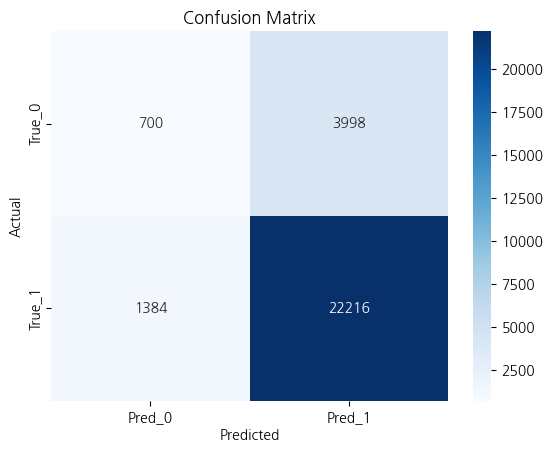

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# 클래스 이름과 이진화
classes = grid.best_estimator_.classes_

# 모델 확률 예측
y_prob = grid.predict_proba(X_test)

# 각 클래스별 최적 threshold 찾기
best_thresholds = {}
for i, cls in enumerate(classes):
    best_f1 = 0
    best_t = 0
    thresholds_to_try = np.linspace(0.1, 0.9, 81)  # 0.1~0.9까지 0.01 간격
    for t in thresholds_to_try:
        y_pred_cls = (y_prob[:, i] >= t).astype(int)
        f1 = f1_score(y_test.values, y_pred_cls)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[cls] = best_t
    print(f"Class {cls}: Best Threshold = {best_t:.2f}, Best F1 = {best_f1:.4f}")

# 최적 threshold 적용 후 멀티클래스 예측
y_pred_thresholded = []
for p in y_prob:
    # threshold 미만 확률은 0으로
    adjusted_p = np.array([prob if prob >= best_thresholds[cls] else 0
                           for cls, prob in zip(classes, p)])
    # 최대값 선택
    y_pred_thresholded.append(classes[np.argmax(adjusted_p)])
y_pred = np.array(y_pred_thresholded)

# 평가
print("\nClassification Report (Threshold Optimized):")
print(classification_report(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob[:, 1], average='macro')
print(f"ROC-AUC (OvO, macro, Test Set): {roc_auc_ovo:.3f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PR-AUC 계산
pr_auc_dict = {}
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test.values, y_prob[:, i])
    pr_auc = auc(recall, precision)
    pr_auc_dict[cls] = pr_auc
    print(f"Class {cls} - PR-AUC: {pr_auc:.4f}")

pr_auc_macro = np.mean(list(pr_auc_dict.values()))
print(f"Macro-average PR-AUC: {pr_auc_macro:.4f}")

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
Class 0: Best Threshold = 0.10, Best F1 = 0.7158
Class 1: Best Threshold = 0.10, Best F1 = 0.9093

Classification Report (Threshold Optimized):
              precision    recall  f1-score   support

           0       0.34      0.15      0.21      4698
           1       0.85      0.94      0.89     23600

    accuracy                           0.81     28298
   macro avg       0.59      0.55      0.55     28298
weighted avg       0.76      0.81      0.78     28298

Balanced Accuracy: 0.5451777532451603
ROC-AUC (OvO, macro, Test Set): 0.616
Confusion Matrix:
[[  700  3998]
 [ 1384 22216]]
Class 0 - PR-AUC: 0.7768
Class 1 - PR-AUC: 0.8834
Macro-average PR-AUC: 0.8301


In [ ]:
best_model = grid.best_estimator_

In [ ]:
# SPLIT
ax = lgb.plot_importance(best_model, max_num_features=3, importance_type='split')
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')

# GAIN
ax = lgb.plot_importance(best_model, max_num_features=3, importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')

In [ ]:
X_train.shape, X_test.shape

((30075, 8), (28298, 8))

In [ ]:
grid

In [ ]:
grid.best_params_

{'model__learning_rate': 0.05,
 'model__max_depth': 20,
 'model__min_child_samples': 3,
 'model__min_gain_to_split': 0,
 'model__n_estimators': 400,
 'model__num_leaves': 127}

In [ ]:
model = best_model.named_steps['model']

/home/dataiku/eric/anaconda3/envs/smartfarm/lib/python3.10/site-packages/shap/explainers/_tree.py:586: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



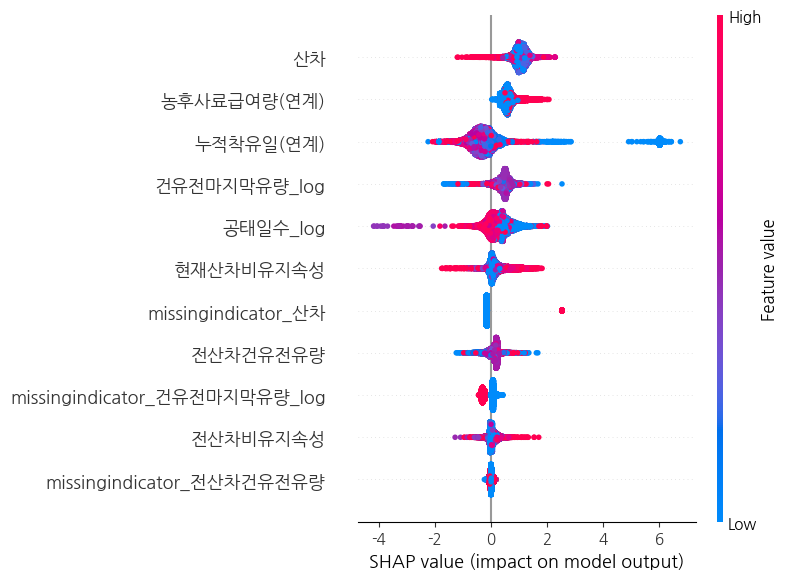

In [ ]:
import shap


# Pipeline에서 feature transformation만 적용하기
X_test_transformed = best_model.named_steps['imputer'].transform(X_test)
# 위에서 StandardScaler도 넣었다면:
# X_test_transformed = pipeline.named_steps['scaler'].transform(X_test_transformed)

# SHAP 적용
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_transformed)

# Plot
shap.summary_plot(shap_values, X_test_transformed)


In [ ]:
import numpy as np
import pandas as pd

# mean absolute shap value per feature
shap_importance = np.abs(shap_values).mean(axis=0)
print(shap_importance)
shap_df = pd.DataFrame({
    'feature': X_test_transformed.columns,
    'shap_importance': shap_importance
}).sort_values(by='shap_importance', ascending=False)

print(shap_df)


[0.55087927 0.11358495 0.30400415 0.46397222 0.18988379 1.03608342
 0.66233305 0.35444859 0.16871191 0.03403957 0.20488709]
                          feature  shap_importance
5                              산차         1.036083
6                     농후사료급여량(연계)         0.662333
0                       누적착유일(연계)         0.550879
3                    건유전마지막유량_log         0.463972
7                        공태일수_log         0.354449
2                       현재산차비유지속성         0.304004
10            missingindicator_산차         0.204887
4                        전산차건유전유량         0.189884
8   missingindicator_건유전마지막유량_log         0.168712
1                        전산차비유지속성         0.113585
9       missingindicator_전산차건유전유량         0.034040


In [ ]:
best_model.booster_.save_model('/content/drive/MyDrive/꾸러기_수비대/lgbm_booster.txt')

In [ ]:
import pickle

# 저장
with open('/content/drive/MyDrive/꾸러기_수비대/lgbm_pkl.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
# 불러오기
with open('/content/drive/MyDrive/꾸러기_수비대/lgbm_pkl.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)

In [ ]:
# 예측
y_pred = loaded_clf.predict(X_test)